# Running LLaVa-Onevision: a multi-modal model for image and video modalities on Google Colab

LLaVa-Onevision is a new Vision-Language Model that enables interaction with videos and images in one model. The model is based on a previuos series of models like [LLaVa-Interleave](https://huggingface.co/collections/llava-hf/llava-interleave-668e19a97da0036aad4a2f19) and [LLaVa-NeXT](https://huggingface.co/collections/llava-hf/llava-next-65f75c4afac77fd37dbbe6cf). The architecutre is very simiilar to LLaVa-NeXT and employs anyres technique to handle high resolution images efficiently. The base LLM is [Qwen2-Instruct](https://huggingface.co/collections/Qwen/qwen2-6659360b33528ced941e557f) where smallest model is only 0.5 billion parameters. That makes LLaVA-Onevision perfect for those who are short on computational resources

LLaVA-OneVision is the first single model that can simultaneously push the performance boundaries of open LMMs in three important computer vision scenarios: single-image, multi-image, and video scenarios. Importantly, the design of LLaVA-OneVision allows strong transfer learning across different modalities/scenarios, yielding new emerging capabilities. In particular, strong video understanding and cross-scenario capabilities are demonstrated through task transfer from images to videos

Transformers docs: https://huggingface.co/docs/transformers/main/en/model_doc/llava_onevision
project page: https://github.com/LLaVA-VL/LLaVA-NeXT/tree/main



First we need to install the latest `transformers` from `branch`, as the model has just been added and the PR isn't merged yet. Also we'll install `bitsandbytes` to load the model in lower bits for [memory efficiency](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

In [ ]:
!pip install --upgrade -q accelerate bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 2.6 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-ta90xffe
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ta90xffe
  Resolved https://github.com/huggingface/transformers.git to commit 47b096412da9cbeb9351806e9f0eb70a693b2859
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9675116 sha256=05252795c3c0b7bc1284f3fd7cae451357a2a18e4eedb7ce8d86606749d7123c
  Stored in directory: /tmp/pip-ephem-wheel-cache-w0swk4uf/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found 

In [1]:
# we need av to be able to read the video
!pip install -q av

In [1]:
import os
# set cuda devices to specific gpus
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"  # Set to the GPU IDs you want to use

## Load the model

Next, we load a model and corresponding processor from the hub.

We will specify a quantization config to load the model in 4 bits. Please refer to this [guide](https://huggingface.co/blog/4bit-transformers-bitsandbytes) for more details.

In [19]:
from transformers import BitsAndBytesConfig, LlavaOnevisionForConditionalGeneration, LlavaOnevisionProcessor
import torch

# quantization_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.float16
# )

model = LlavaOnevisionForConditionalGeneration.from_pretrained("llava-hf/llava-onevision-qwen2-7b-ov-hf", torch_dtype="float16", device_map='auto')
processor = LlavaOnevisionProcessor.from_pretrained("llava-hf/llava-onevision-qwen2-0.5b-ov-hf")
processor.tokenizer.padding_side = "left" # set to 'left' for generation and 'right' for training (default in 'right')

# Uncomment below if you want to use 7B model and load it in consumer hardware
# Qunatizing model to 4bits will save memory up to 4 times
# model = LlavaOnevisionForConditionalGeneration.from_pretrained(
#     "llava-hf/llava-onevision-qwen2-7b-ov-hf",
#     quantization_config=quantization_config,
#     device_map='auto'
# )

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
/datassd4/users/hardik/miniconda3/envs/vllm/lib/python3.12/site-packages/accelerate/utils/modeling.py:1614: UserWarning: The following device_map keys do not match any submodules in the model: ['model.image_newline']
  warnings.warn(


In [3]:
from transformers import LlavaNextVideoProcessor, LlavaNextVideoForConditionalGeneration
import torch
model_id = "llava-hf/LLaVA-NeXT-Video-7B-hf"

model = LlavaNextVideoForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    device_map='auto'
)

processor = LlavaNextVideoProcessor.from_pretrained(model_id)

processor.tokenizer.padding_side = "left" # set to 'left' for generation and 'right' for training (default in 'right')


Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]
/datassd4/users/hardik/miniconda3/envs/vllm/lib/python3.12/site-packages/accelerate/utils/modeling.py:1614: UserWarning: The following device_map keys do not match any submodules in the model: ['model.image_newline']
  warnings.warn(
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Preparing the video and image inputs

In order to read the video we'll use `av` and sample 8 frames. You can try to sample more frames if the video is long. The model was trained with 32 frames, but can ingest more as long as we're in the LLM backbone's max sequence length range.

In [4]:
import av
import numpy as np

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.

    Args:
        container (av.container.input.InputContainer): PyAV container.
        indices (List[int]): List of frame indices to decode.

    Returns:
        np.ndarray: np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [ ]:
from huggingface_hub import hf_hub_download

# Download video from the hub
video_path_1 = hf_hub_download(repo_id="raushan-testing-hf/videos-test", filename="sample_demo_1.mp4", repo_type="dataset")
video_path_2 = hf_hub_download(repo_id="raushan-testing-hf/videos-test", filename="karate.mp4", repo_type="dataset")

container = av.open(video_path_1)

# sample uniformly 8 frames from the video (we can sample more for longer videos)
total_frames = container.streams.video[0].frames
indices = np.arange(0, total_frames, total_frames / 8).astype(int)
clip_baby = read_video_pyav(container, indices)


container = av.open(video_path_2)

# sample uniformly 8 frames from the video (we can sample more for longer videos)
total_frames = container.streams.video[0].frames
indices = np.arange(0, total_frames, total_frames / 8).astype(int)
clip_karate = read_video_pyav(container, indices)

sample_demo_1.mp4:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

karate.mp4:   0%|          | 0.00/60.7M [00:00<?, ?B/s]

In [26]:
# Custom video
video_path_1 = f"/datassd4/users/hardik/dev/vllm/data/frames/output1.mp4"
container = av.open(video_path_1)

# sample uniformly 8 frames from the video (we can sample more for longer videos)
total_frames = container.streams.video[0].frames
print(total_frames)
indices = np.arange(0, total_frames, total_frames / 10).astype(int)
print(indices)
clip_baby = read_video_pyav(container, indices)


150
[  0  15  30  45  60  75  90 105 120 135]


In [27]:
clip_baby.shape

(10, 778, 1914, 3)

In [29]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = clip_baby

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=500)
HTML(anim.to_html5_video())

In [8]:
from PIL import Image
import numpy as np
import cv2

In [51]:
def get_front3_stitched_image(video_dir,frame_id):
    front_views = [
        np.array(Image.open(os.path.join(video_dir, f"FRONT_LEFT", f"{frame_id}.png"))),
        np.array(Image.open(os.path.join(video_dir, f"FRONT", f"{frame_id}.png"))),
        np.array(Image.open(os.path.join(video_dir, f"FRONT_RIGHT", f"{frame_id}.png"))),
    ]
    stitched_front = np.concatenate(front_views, axis=1)
    # resize the stitched image to 224x224
    stitched_front = Image.fromarray(stitched_front).resize((1194, 778))

    return stitched_front


In [52]:
video_dir = "/datassd4/users/hardik/dev/waymo_e2e/data/0042b483892db48907e04dbf69a049f6"
# frame_ids = ["150", "160", "170", "180", "190"]
frame_ids = [f.split(".")[0] for f in os.listdir(os.path.join(video_dir, "FRONT")) if f.endswith(".png")]
frame_ids = sorted(frame_ids)  # Sort the frame IDs to maintain order
# skip every 2 frames
frame_ids = frame_ids[::7] # take every 2nd frame
# frame_ids = frame_ids[-75:-55] # take only last 25 frames
stitched_images = []
for frame_id in frame_ids:
    front_img = get_front3_stitched_image(video_dir,frame_id)
    stitched_images.append(front_img)

print(f"Total stitched images: {len(stitched_images)}" )

Total stitched images: 33


In [48]:
stitched_images = stitched_images[::7]
len(stitched_images)

33

In [24]:
video_dir_negative = "/datassd4/users/hardik/dev/vllm/data/frames"

frame_ids = [f.split(".")[0] for f in os.listdir(video_dir_negative) if f.endswith(".png")]
frame_ids = sorted(frame_ids)  # Sort the frame IDs to maintain order
# skip every 2 frames
frame_ids = frame_ids[::5] # take every 2nd frame

stitched_images = []
for frame_id in frame_ids:
    front_img = Image.open(os.path.join(video_dir_negative, f"{frame_id}.png"))
    # resize to 224x224
    # front_img = front_img.resize((224, 224))
    stitched_images.append(front_img)
# stitched_images = stitched_images[::]
print(f"Total stitched images: {len(stitched_images)}" )

Total stitched images: 30


In [53]:
'''np.ndarray: np array of decoded frames of shape (num_frames, height, width, 3).
    np.stack([x.to_ndarray(format="rgb24") for x in frames])'''
video_negative = np.stack([np.array(x) for x in stitched_images])
print(f"Video shape: {video_negative.shape}")

Video shape: (33, 778, 1194, 3)


In [54]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video2 = video_negative

fig = plt.figure()
im = plt.imshow(video2[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video2[0,:,:,:])

def animate(i):
    im.set_data(video2[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video2.shape[0],
                               interval=250)
HTML(anim.to_html5_video())

In [9]:

SEGMENT_PROMPT = f"""You are a driving examiner sitting inside the ego vehicle evaluating the subject's driving the ego vehicle. You are given a video segment in form of sequence of images
Based on the full sequence of images, write an observer’s note that addresses:
1. Ego vehicle control: lane position, spacing, following distance.
2. Compliance: traffic signs, signals, right-of-way.
3. Maneuvers: turns, lane changes, or stops.
4. Hazards: any potential risks or conflicts.
5. Overall driving performance for this short segment.
Write the response as if it were part of a DMV behind the wheel driving performance evaluation sheet.
Be concise but specific, describing what happens across the video segment. Give the note in a JSON format with the following keys: "Ego vehicle control", "Compliance", "Maneuvers", "Hazards", "Overall driving performance".
"""

In [34]:
SEGMENT_PROMPT_2 = f"""
You are a DMV driving examiner sitting inside the ego vehicle evaluating the subject's driving the ego vehicle. You are given a video segment in form of sequence of images
(front view from the ego vehicle).

Write the observer’s note in the style of a DMV behind-the-wheel score sheet:
- Use very brief, objective phrases (not full sentences).
- If an event happens at a specific second, reference it (e.g., "at 4s: driver rolls stop").
- If the context matters (e.g., traffic signal, intersection), include it briefly.
- If no issues are seen, write "No issues".
- Keep each field to one line.

Output strictly in JSON with the keys:
"Ego vehicle control", "Compliance", "Maneuvers", "Hazards", "Overall driving performance".
"""


In [10]:
SEGMENT_PROMPT_3 = f"""
You are a DMV driving examiner sitting inside the ego vehicle evaluating the subject's driving the ego vehicle. You are given a video segment in form of sequence of images
(front view from the ego vehicle).

Write the observer’s note in the style of the DMV Driving Performance Evaluation Score Sheet.  
Follow these rules:
- Use very brief, objective phrases (not full sentences).
- Reference the second if applicable (e.g., "at 4s: rolled stop").
- Reference context if applicable (e.g., "at signal", "during merge").
- If no issue observed, write "No issues".
- If a Critical Driving Error occurs, clearly mark it.
- Keep each item to a single line.

Output strictly in JSON format with the following top-level keys:

1) Critical Driving Error with possible flags:
   - "Strikes object/curb"
   - "Disobeys traffic sign or signal"
   - "Disobeys safety personnel/vehicles"
   - "Dangerous maneuver"
   - "Lane violation"
   If none, write "None".

2) Parking Lot Driving: ("Traffic check": ..., "Speed": ... )

3) Freeway/Highway: (
   "Entering": ( "Traffic check": ..., "Speed": ..., "Signal": ..., "Spacing": ..., "Lane Position": ... ),
   "Merge": ( "Traffic check": ..., "Speed": ..., "Signal": ..., "Spacing": ..., "Lane Position": ..., "Steering control": ... ),
   "Lane Use": ( "Traffic check": ..., "Speed": ..., "Spacing": ..., "Lane Position": ... ),
   "Exiting": ( "Traffic check": ..., "Speed": ..., "Signal": ..., "Spacing": ..., "Lane Position": ..., "Steering control": ... )
)

4) Intersections: (
   "Through": ( "Traffic check": ..., "Speed": ..., "Yield": ..., "Unnecessary Stop": ... ),
   "Stop": ( "Traffic check": ..., "Deceleration/Braking": ..., "Full Stop": ..., "Gap/Limit line": ... ),
   "Start": ( "Traffic check": ..., "Speed": ..., "Yield": ... )
)

5) Business/Urban and Residential/Rural: ( "Traffic check": ..., "Speed": ..., "Spacing": ..., "Lane Position": ... )

6) Backing: ( "Traffic check": ..., "Speed": ..., "Signal": ..., "Parallel": ..., "Control": ... )

7) Turns: (
   "Approach": ( "Traffic check": ..., "Signal": ..., "Deceleration/Braking": ..., "Yield": ..., "Lane use": ..., "Unnecessary Stop": ... ),
   "Stop": ( "Traffic check": ..., "Wheels straight": ..., "Full Stop": ..., "Gap/Limit line": ... ),
   "Turn/Complete": ( "Traffic check": ..., "Speed": ..., "Signal": ..., "Steering control": ..., "Yield": ..., "Too wide/short": ..., "Correct Lane": ... )
)

8) Driving Improvement Checklist: (
   "Stops": "...",
   "Lane Use": "...",
   "Lane Change": "...",
   "Speed": "...",
   "Traffic Check": "...",
   "Vehicle Control": "...",
   "Yielding": "..."
)
"""


In [14]:
# Each "content" is a list of dicts and you can add image/video/text modalities
conversation_image = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": SEGMENT_PROMPT},
              ],
      },
]
conversation_image[0]["content"].extend([{"type": "image"}]*len(stitched_images))  # add all images to the content
conversation_image2 = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": SEGMENT_PROMPT_2},
              ],
      },
]
conversation_image2[0]["content"].extend([{"type": "image"}]*len(stitched_images))  # add all images to the content
conversation_image3 = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": SEGMENT_PROMPT_3},
              ],
      },
]
conversation_image3[0]["content"].extend([{"type": "image"}]*len(stitched_images))  # add all images to the content

prompt_image = processor.apply_chat_template(conversation_image, add_generation_prompt=True)
prompt_image2 = processor.apply_chat_template(conversation_image2, add_generation_prompt=True)
prompt_image3 = processor.apply_chat_template(conversation_image3, add_generation_prompt=True)

In [30]:
SEGMENT_PROMPT_4 = f"""
you are an officer examining the ego-vehicle driver as part of behind the wheel driving test. You are provided with a video of the driver operating the vehicle. Your task is to make observer's note that addresses mistakes made by the driver. You must base your observations on the video content only and avoid making assumptions beyond what is shown. Strictly adhere to
short and concise notes, avoiding unnecessary elaboration. eg. "2s: Did not stop at Red Signal", "4s: Hard brake", "at circle, did not yield".
If there's nothing specific to note, then just mention "clear".
"""

In [31]:
conversation_image4 = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": SEGMENT_PROMPT_4},
              {"type" : "video"}
              ],
      },
]
# conversation_image4[0]["content"].extend([{"type": "image"}]*len(stitched_images))  # add all images to the content

prompt_image4 = processor.apply_chat_template(conversation_image4, add_generation_prompt=True)
prompt_image4

'<|im_start|>user <video>\n\nyou are an officer examining the ego-vehicle driver as part of behind the wheel driving test. You are provided with a video of the driver operating the vehicle. Your task is to make observer\'s note that addresses mistakes made by the driver. You must base your observations on the video content only and avoid making assumptions beyond what is shown. Strictly adhere to\nshort and concise notes, avoiding unnecessary elaboration. eg. "2s: Did not stop at Red Signal", "4s: Hard brake", "at circle, did not yield".\nIf there\'s nothing specific to note, then just mention "clear".\n<|im_end|><|im_start|>assistant\n'

In [14]:
conversation_image4

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'How many lanes do you see in the video at each time step? Count the cars in each lane. Describe the scene in detail.'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'},
   {'type': 'image'}]}]

In [32]:
inputs4 = processor(text=[prompt_image4], videos=[clip_baby],  padding=True, return_tensors="pt").to(model.device)

In [33]:
generate_kwargs = {"max_new_tokens": 1000, "do_sample": True, "top_p": 0.6}

output4 = model.generate(**inputs4, **generate_kwargs)
generated_text4 = processor.batch_decode(output4, skip_special_tokens=True)
print(generated_text4)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


['user \n\nyou are an officer examining the ego-vehicle driver as part of behind the wheel driving test. You are provided with a video of the driver operating the vehicle. Your task is to make observer\'s note that addresses mistakes made by the driver. You must base your observations on the video content only and avoid making assumptions beyond what is shown. Strictly adhere to\nshort and concise notes, avoiding unnecessary elaboration. eg. "2s: Did not stop at Red Signal", "4s: Hard brake", "at circle, did not yield".\nIf there\'s nothing specific to note, then just mention "clear".\nassistant\nThe driver did not stop at the red traffic light at the intersection, resulting in a traffic violation.']


In [39]:
generate_kwargs = {"max_new_tokens": 1000, "do_sample": True, "top_p": 0.9}

output4 = model.generate(**inputs4, **generate_kwargs)
generated_text4 = processor.batch_decode(output4, skip_special_tokens=True)
print(generated_text4)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


['user \n\nyou are an officer examining the ego-vehicle driver as part of behind the wheel driving test. You are provided with a \nvideo of the driver operating the vehicle which has 30 frames over span of 7 sec. Your task is to make observer\'s note that addresses \nmistakes made by the driver. You must base your observations on the video content only and avoid making assumptions beyond what is shown. Strictly adhere to\nshort and concise notes, avoiding unnecessary elaboration. eg. "2s: Did not stop at Red Signal", "4s: Hard brake", "at circle, did not yield. \nIf there\'s nothing specific to note, then just mention "clear".\nassistant\nThe driver stopped at the red signal, performed a smooth turn when changing lanes, and maintained a safe following distance. There were no noticeable mistakes during the driving test.']


In [15]:
inputs = processor(images=stitched_images, text=[prompt_image], padding=True, return_tensors="pt").to(model.device, torch.float16)

In [16]:
inputs2 = processor(images=stitched_images, text=[prompt_image2], padding=True, return_tensors="pt").to(model.device, torch.float16)

In [17]:
inputs3 = processor(images=stitched_images, text=[prompt_image3], padding=True, return_tensors="pt").to(model.device, torch.float16)

In [18]:
generate_kwargs = {"max_new_tokens": 1000, "do_sample": True, "top_p": 0.9}

output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


['user \nYou are a driving examiner sitting inside the ego vehicle evaluating the subject\'s driving the ego vehicle. You are given a video segment in form of sequence of images\nBased on the full sequence of images, write an observer’s note that addresses:\n1. Ego vehicle control: lane position, spacing, following distance.\n2. Compliance: traffic signs, signals, right-of-way.\n3. Maneuvers: turns, lane changes, or stops.\n4. Hazards: any potential risks or conflicts.\n5. Overall driving performance for this short segment.\nWrite the response as if it were part of a DMV behind the wheel driving performance evaluation sheet.\nBe concise but specific, describing what happens across the video segment. Give the note in a JSON format with the following keys: "Ego vehicle control", "Compliance", "Maneuvers", "Hazards", "Overall driving performance".\nassistant\n```json\n{\n  "Ego vehicle control": [\n    "The ego vehicle is consistently centered within its lane throughout the observed seque

In [19]:
output2 = model.generate(**inputs2, **generate_kwargs)
generated_text2 = processor.batch_decode(output2, skip_special_tokens=True)
print(generated_text2)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


['user \n\nYou are a DMV driving examiner sitting inside the ego vehicle evaluating the subject\'s driving the ego vehicle. You are given a video segment in form of sequence of images\n(front view from the ego vehicle).\n\nWrite the observer’s note in the style of a DMV behind-the-wheel score sheet:\n- Use very brief, objective phrases (not full sentences).\n- If an event happens at a specific second, reference it (e.g., "at 4s: driver rolls stop").\n- If the context matters (e.g., traffic signal, intersection), include it briefly.\n- If no issues are seen, write "No issues".\n- Keep each field to one line.\n\nOutput strictly in JSON with the keys:\n"Ego vehicle control", "Compliance", "Maneuvers", "Hazards", "Overall driving performance".\nassistant\n```json\n{\n  "Ego vehicle control": "Consistent speed, steering is smooth",\n  "Compliance": "All traffic signals obeyed, lane discipline maintained",\n  "Maneuvers": "Proper signaling for turns, consistent braking",\n  "Hazards": "No ma

In [20]:
output3 = model.generate(**inputs3, **generate_kwargs)
generated_text3 = processor.batch_decode(output3, skip_special_tokens=True)
print(generated_text3)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


['user \n\nYou are a DMV driving examiner sitting inside the ego vehicle evaluating the subject\'s driving the ego vehicle. You are given a video segment in form of sequence of images\n(front view from the ego vehicle).\n\nWrite the observer’s note in the style of the DMV Driving Performance Evaluation Score Sheet.  \nFollow these rules:\n- Use very brief, objective phrases (not full sentences).\n- Reference the second if applicable (e.g., "at 4s: rolled stop").\n- Reference context if applicable (e.g., "at signal", "during merge").\n- If no issue observed, write "No issues".\n- If a Critical Driving Error occurs, clearly mark it.\n- Keep each item to a single line.\n\nOutput strictly in JSON format with the following top-level keys:\n\n1) Critical Driving Error with possible flags:\n   - "Strikes object/curb"\n   - "Disobeys traffic sign or signal"\n   - "Disobeys safety personnel/vehicles"\n   - "Dangerous maneuver"\n   - "Lane violation"\n   If none, write "None".\n\n2) Parking Lot 

In [24]:
generated_text[0].split('assistant')[1].strip()

"**Observer's Note**\n\n**Ego Vehicle Control:**\n- Lane Position: The ego vehicle maintains a consistent lane position, exhibiting controlled driving.\n- Spacing: The vehicle is observed to maintain a safe distance from other road users, showing awareness of following distance.\n\n**Compliance:**\n- Traffic Signs and Signals: The ego vehicle displays compliance with traffic rules, stopping at the traffic signal and yielding to other road users when required.\n- Right-of-Way: The vehicle demonstrates proper right-of-way rules, especially evident when yielding to other vehicles at intersections.\n\n**Maneuvers:**\n- Turns and Lane Changes: The vehicle executes turns and lane changes smoothly, without abrupt movements.\n- Stops: The vehicle comes to a complete stop at a red traffic light and follows pedestrian crossings.\n\n**Hazards:**\n- Potential Risks: Throughout the segment, the ego vehicle does not appear to face any immediate hazards that would require a maneuver to prevent collis

In [23]:
import json
import re

match = re.search(r"\{.*\}", generated_text3[0], re.DOTALL)
if match:
    json_str = match.group(0)
    
    # 2. Parse into Python dict
    data = json.loads(json_str)
    
    # 3. Save as JSON file
    with open("observer_notes_negative_3.json", "w") as f:
        json.dump(data, f, indent=2)
    
    print("JSON saved successfully!")
else:
    print("No JSON found in output.")

JSON saved successfully!


In [ ]:
# Lets also load 2 images for generation from image data

from PIL import Image
import requests

image_stop = Image.open(requests.get("https://www.ilankelman.org/stopsigns/australia.jpg", stream=True).raw)
image_snowman = Image.open(requests.get("https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg", stream=True).raw)

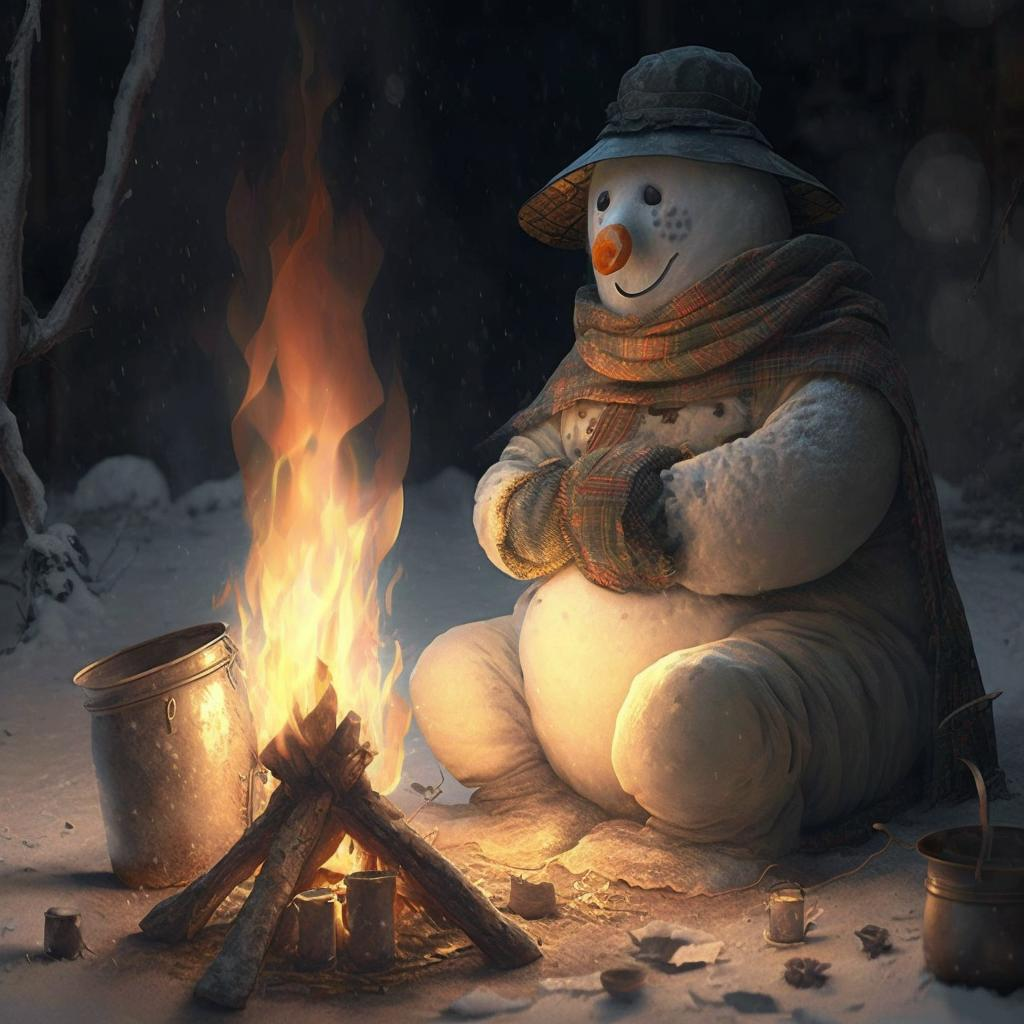

In [ ]:
image_snowman

## Prepare a prompt and generate

In the prompt, you can refer to video using the special `<video>` or `<image>` token. To indicate which text comes from a human vs. the model, one uses `user` and `assistant` respectively. The chat format looks as follows:

`"<|im_start|>user <image>\n<prompt1><|im_end|><|im_start|>assistant <answer1><|im_end|><|im_start|>user <image>\n<prompt1><|im_end|><|im_start|>assistant "
`

In other words, you always need to end your prompt with `<|im_start|>assistant` if yuo want to chat with the model:.

Manually formatting your prompt can be error-prone. Luckily we can use `apply_chat_template` to make it easier.

Chat templates are special templates written in jinja and added to the model's config. Whenever we call `apply_chat_template`, the jinja template in filled in with your text instruction.

To use chat template simply build a list of messages, with role and content keys, and then pass it to the `apply_chat_template()` method. Once you do that, you’ll get output that’s ready to go! When using chat templates as input for model generation, it’s also a good idea to use `add_generation_prompt=True` to add a generation prompt. See [the docs](https://huggingface.co/docs/transformers/main/en/chat_templating) for more details

In [ ]:
# Each "content" is a list of dicts and you can add image/video/text modalities
conversation = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "Why is this video funny?"},
              {"type": "image"},
              ],
      },
]

conversation_2 = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What do you see in this video?"},
              {"type": "video"},
              ],
      },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
prompt_2 = processor.apply_chat_template(conversation_2, add_generation_prompt=True)

In [ ]:
# As you can see we got the formatted prompt
prompt

'<|im_start|>user <video>\nWhy is this video funny?<|im_end|><|im_start|>assistant\n'

In [ ]:
# we still need to call the processor to tokenize the prompt and get pixel_values for videos
inputs = processor(text=[prompt, prompt_2], videos=[clip_baby, clip_karate], padding=True, return_tensors="pt").to(model.device, torch.float16)

In [ ]:
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [ ]:
print(generated_text)

['user \nWhy is this video funny?assistant\nThe video is humorous because the baby is seen wearing glasses and reading a book in a room with a cozy and inviting atmosphere.', 'user \nWhat do you see in this video?assistant\nA person dressed in a white gi, sitting in a meditation pose on a mat with a window in the background and light streaming in through large windows.']


### Generate from images and image+video data

To generate from images we have to change the special token to `<image>` or indicate an "image" modality in the chat template, that's it! Let's see how it works

In [ ]:
# Each "content" is a list of dicts and you can add image/video/text modalities
conversation_image = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What do you see in this image?"},
              {"type": "image"},
              ],
      },
]

conversation_2_image = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What color is the sign?"},
              {"type": "image"},
              ],
      },
]

prompt_image = processor.apply_chat_template(conversation_image, add_generation_prompt=True)
prompt_2_image = processor.apply_chat_template(conversation_2_image, add_generation_prompt=True)

In [ ]:
prompt

'<|im_start|>user <video>\nWhy is this video funny?<|im_end|><|im_start|>assistant\n'

In [ ]:
inputs = processor(images=[image_snowman, image_stop], text=[prompt_image, prompt_2_image], padding=True, return_tensors="pt").to(model.device, torch.float16)

In [ ]:
generate_kwargs = {"max_new_tokens": 50, "do_sample": True, "top_p": 0.9}

output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [ ]:
print(generated_text)

['user \nWhat do you see in this image?assistant\nIn the image, a snowman sits comfortably in a cozy campfire. The snowman, complete with a hat, scarf, and gloves, is the central figure. He is surrounded by small pots and a kettle, which are placed on the ground', 'user \nWhat color is the sign?assistant\nThe sign is red.']


We can feed images and videos in one go instead of running separate generations for image and video. Also we can interleave images with videos inside one prompt, although the training dataset didn't see that kind of examples.

For the processing just make sure to pass images/videos in the same order as they appear in the prompts, starting from the first prompt until the last prompt. You can pass all visual data as flattenned list as shown below, only order matters





In [ ]:
inputs = processor(images=[image_snowman, image_stop], text=[prompt, prompt_image, prompt_2_image], videos=[clip_baby], padding=True, return_tensors="pt").to(model.device, torch.float16)

In [ ]:
generate_kwargs = {"max_new_tokens": 40, "do_sample": True, "top_p": 0.9}

output = model.generate(**inputs, **generate_kwargs)
generated_text = processor.batch_decode(output, skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


['user \nWhy is this video funny?assistant\nThe video is humorous because the young child is seen with an oversized book in their hands, which creates a comedic and exaggerated scenario.', 'user \nWhat do you see in this image?assistant\nThe image depicts a snowman sitting by a roaring campfire at night. The snowman is wearing a hat, scarf, and gloves, and has a carrot nose. The fire is fueled by logs', 'user \nWhat color is the sign?assistant\nRed']


In [ ]:
# For multi-turn convwersations just continue stacking up messages in the chat template
conversation_multiturn = [
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "What do you see in this video?"},
              {"type": "video"},
              ],
      },
      {
          "role": "assistant",
          "content": [
              {"type": "text", "text": "I see a baby reading a book."},
              ],
      },
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "Why is it funny?"},
              ],
      },
]

prompt_multiturn = processor.apply_chat_template(conversation_multiturn, add_generation_prompt=True)
print(prompt_multiturn)

<|im_start|>user <video>
What do you see in this video?<|im_end|><|im_start|>assistant 
I see a baby reading a book.<|im_end|><|im_start|>user 
Why is it funny?<|im_end|><|im_start|>assistant

